In [1]:
from __future__ import print_function
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
import keras
from keras import metrics
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import Adam, RMSprop, Nadam
from keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from keras.utils import plot_model
from keras.models import load_model

Using TensorFlow backend.


              open    high       low   close    volume
date                                                  
2013-12-16  148.48  150.43  146.1000  147.94   6675276
2013-12-17  147.58  154.63  146.3235  152.46  10494969
2013-12-18  152.24  154.90  145.9500  147.98  11581897
2013-12-19  146.90  147.00  139.1000  140.72  12758613
2013-12-20  141.58  144.35  141.5800  143.24   7422537


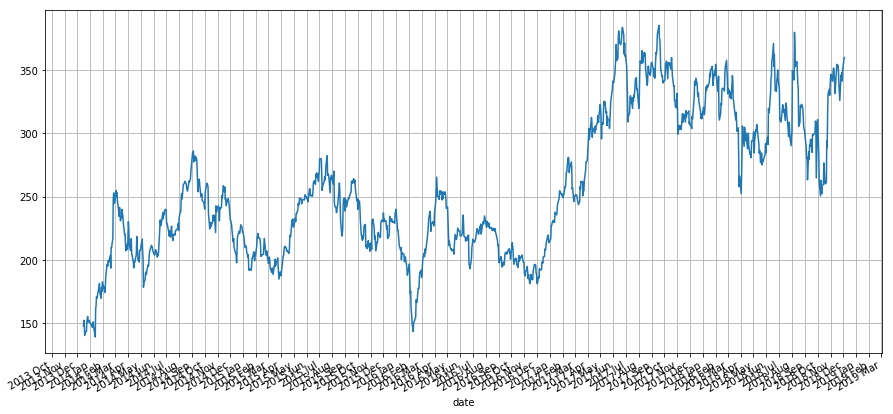

In [3]:
from crawler import *
tsla = stockInfo("TSLA",0)
tsla.getFromIEX( tsla.date(2013,1,1), tsla.date(2018, 12, 4))
tsla.addLabel()

In [4]:

clone = tsla.data.drop("date", axis=1)
clone = clone.drop( len(clone)-1, axis = 0)
print(clone.head())

     open    high       low   close    volume  nextDay
0  148.48  150.43  146.1000  147.94   6675276   152.46
1  147.58  154.63  146.3235  152.46  10494969   147.98
2  152.24  154.90  145.9500  147.98  11581897   140.72
3  146.90  147.00  139.1000  140.72  12758613   143.24
4  141.58  144.35  141.5800  143.24   7422537   143.55


In [6]:
from sklearn import preprocessing
for col in clone:
    if col == 'nextDay':
        break
    clone[col] = preprocessing.scale(clone[col] )
clone.describe()

,open,high,low,close,volume,nextDay
count,1251.000000,1.251000e+03,1.251000e+03,1251.000000,1.251000e+03,1251.000000
mean,0.000000,-9.087677e-17,9.087677e-17,0.000000,3.407879e-17,256.849058
std,1.000400,1.000400e+00,1.000400e+00,1.000400,1.000400e+00,55.506557
min,-2.091512,-2.073586e+00,-2.113079e+00,-2.114484,-1.431203e+00,139.340000
25%,-0.793978,-7.915469e-01,-8.035328e-01,-0.799281,-6.195133e-01,212.585000
50%,-0.190263,-2.051299e-01,-1.821730e-01,-0.188307,-2.601340e-01,246.600000
75%,0.855693,8.511128e-01,8.580902e-01,0.871009,2.940838e-01,305.110000
max,2.340535,2.288695e+00,2.325121e+00,2.312353,7.234097e+00,385.000000


In [7]:
testNum = 100
matrix_train = np.matrix(clone)
matrix_test = matrix_train[len(matrix_train)-testNum:len(matrix_train),:]
matrix_train = matrix_train[ 0: len(matrix_train)-testNum, :]
print(len(matrix_train))

1151


In [8]:
validNum = int(len(matrix_train)/10)
print(validNum)
matrix_validation = matrix_train[len(matrix_train)-validNum:len(matrix_train),:]
matrix_train = matrix_train[ 0: len(matrix_train)-validNum, :] 

115


In [9]:
print(len(clone))
print(len(matrix_train))
print(len(matrix_validation))
print(len(matrix_test))

1251
1036
115
100


In [10]:
FEATURES = list(clone.columns)
FEATURES.remove('nextDay')
LABEL = "nextDay"
test_set = matrix_test[:, 0:matrix_test.shape[1]-1]
test_y = matrix_test[:, matrix_test.shape[1]-1]
train_set = matrix_train[:, 0: matrix_train.shape[1]-1]
train_y = matrix_train[:, matrix_train.shape[1]-1]
validation_set = matrix_validation[:, 0:matrix_validation.shape[1]-1]
validation_y = matrix_validation[:, matrix_validation.shape[1]-1]
print(train_set)

[[-1.94785157 -1.96544544 -1.94063491 -1.9595102   0.13799602]
 [-1.96405386 -1.89074275 -1.93654738 -1.878059    1.14283432]
 [-1.880162   -1.88594044 -1.94337822 -1.9587894   1.4287701 ]
 ...
 [ 1.76247308  1.66866255  1.66992713  1.60758389 -0.22708897]
 [ 1.64887702  1.56994828  1.53971134  1.45891743  0.15510253]
 [ 1.52699978  1.47745924  1.52709211  1.55280255 -0.42389579]]


In [11]:
def basic_model_2(x_size, y_size, first_N, sec_N, thrid_N, drop_R):
    t_model = Sequential()
    t_model.add(Dense(first_N, activation="tanh", input_shape=(x_size,)))
    t_model.add(Dropout(drop_R))
    t_model.add(Dense(sec_N, activation="relu"))
    t_model.add(Dense(thrid_N, activation="relu"))
    t_model.add(Dense(y_size))
    print(t_model.summary())
    t_model.compile(loss='mean_squared_error',
        optimizer=Adam(),
        metrics=[metrics.mae])
    return(t_model)

In [12]:
def basic_model_3(x_size, y_size):
    t_model = Sequential()
    t_model.add(Dense(5, activation="tanh", kernel_initializer='normal', input_shape=(x_size,)))
    #t_model.add(Dropout(0.2))
    t_model.add(Dense(50, activation="relu", kernel_initializer='normal', 
        kernel_regularizer=regularizers.l1(0.01), bias_regularizer=regularizers.l1(0.01)))
    #t_model.add(Dropout(0.1))
    t_model.add(Dense(100, activation="relu", kernel_initializer='normal', 
        kernel_regularizer=regularizers.l1_l2(0.01), bias_regularizer=regularizers.l1_l2(0.01)))
    #t_model.add(Dropout(0.1))
    t_model.add(Dense(100, activation="relu", kernel_initializer='normal', 
        kernel_regularizer=regularizers.l1_l2(0.01), bias_regularizer=regularizers.l1_l2(0.01)))
    #t_model.add(Dropout(0.1))
    t_model.add(Dense(100, activation="relu", kernel_initializer='normal', 
        kernel_regularizer=regularizers.l1_l2(0.01), bias_regularizer=regularizers.l1_l2(0.01)))
    #t_model.add(Dropout(0.1))
    t_model.add(Dense(100, activation="relu", kernel_initializer='normal', 
        kernel_regularizer=regularizers.l1_l2(0.01), bias_regularizer=regularizers.l1_l2(0.01)))
    #t_model.add(Dropout(0.1))
    t_model.add(Dense(100, activation="relu", kernel_initializer='normal', 
        kernel_regularizer=regularizers.l1_l2(0.01), bias_regularizer=regularizers.l1_l2(0.01)))
    #t_model.add(Dropout(0.1))
    t_model.add(Dense(500, activation="relu", kernel_initializer='normal', 
        kernel_regularizer=regularizers.l1_l2(0.01), bias_regularizer=regularizers.l1_l2(0.01)))
    #t_model.add(Dropout(0.1))
    t_model.add(Dense(100, activation="relu", kernel_initializer='normal', 
        kernel_regularizer=regularizers.l1_l2(0.01), bias_regularizer=regularizers.l1_l2(0.01)))
    t_model.add(Dense(100, activation="relu", kernel_initializer='normal', 
        kernel_regularizer=regularizers.l1_l2(0.01), bias_regularizer=regularizers.l1_l2(0.01)))
    #t_model.add(Dropout(0.1))
    t_model.add(Dense(50, activation="relu", kernel_initializer='normal', 
        kernel_regularizer=regularizers.l1_l2(0.01), bias_regularizer=regularizers.l1_l2(0.01)))
    #t_model.add(Dropout(0.1))
    t_model.add(Dense(50, activation="relu", kernel_initializer='normal', 
        kernel_regularizer=regularizers.l1_l2(0.01), bias_regularizer=regularizers.l1_l2(0.01)))
    #t_model.add(Dropout(0.1))
    t_model.add(Dense(10, activation="relu", kernel_initializer='normal'))
    #t_model.add(Dropout(0.0))
    t_model.add(Dense(y_size))
    #keras.optimizers.Nadam(lr=0.000001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, schedule_decay=0.004)
    t_model.compile(
        
        loss='mean_squared_error',
        optimizer=Nadam(lr=0.00001, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004),
        metrics=[metrics.mae])
    return(t_model)

In [13]:
#model = basic_model_2(train_set.shape[1], train_y.shape[1], 100, 50, 20, 0.1)
print(train_set.shape[1])
model = basic_model_3(train_set.shape[1], train_y.shape[1])
model.summary()

5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 5)                 30        
_________________________________________________________________
dense_2 (Dense)              (None, 50)                300       
_________________________________________________________________
dense_3 (Dense)              (None, 100)               5100      
_________________________________________________________________
dense_4 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_5 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_6 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_7 (Dense)              (None, 100)               10100     
________

In [14]:
epochs = 1000
batch_size = 64

print('Epochs: ', epochs)
print('Batch size: ', batch_size)

Epochs:  1000
Batch size:  64


In [15]:
keras_callbacks = [
    # ModelCheckpoint('/tmp/keras_checkpoints/model.{epoch:02d}-{val_loss:.2f}.hdf5', monitor='val_loss', save_best_only=True, verbose=2)
    # ModelCheckpoint('/tmp/keras_checkpoints/model.{epoch:02d}.hdf5', monitor='val_loss', save_best_only=True, verbose=0)
    TensorBoard(log_dir='./keras/model_3', histogram_freq=0, write_graph=True, write_images=True, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None),
    EarlyStopping(monitor='val_mean_absolute_error', patience=20, verbose=0)
]

In [16]:
history = model.fit(train_set, train_y,
    batch_size=batch_size,
    epochs=epochs,
    shuffle=True,
    verbose=2, # Change it to 2, if wished to observe execution
    validation_data=(validation_set, validation_y),
    callbacks=keras_callbacks)


Train on 1036 samples, validate on 115 samples
Epoch 1/1000
 - 2s - loss: 62876.8080 - mean_absolute_error: 245.0803 - val_loss: 99196.8927 - val_mean_absolute_error: 313.7790
Epoch 2/1000
 - 0s - loss: 62876.2592 - mean_absolute_error: 245.0797 - val_loss: 99196.2008 - val_mean_absolute_error: 313.7784
Epoch 3/1000
 - 0s - loss: 62875.6495 - mean_absolute_error: 245.0791 - val_loss: 99195.5055 - val_mean_absolute_error: 313.7777
Epoch 4/1000
 - 0s - loss: 62875.0348 - mean_absolute_error: 245.0784 - val_loss: 99194.7711 - val_mean_absolute_error: 313.7770
Epoch 5/1000
 - 0s - loss: 62874.4199 - mean_absolute_error: 245.0778 - val_loss: 99194.0680 - val_mean_absolute_error: 313.7764
Epoch 6/1000
 - 0s - loss: 62873.7983 - mean_absolute_error: 245.0771 - val_loss: 99193.3536 - val_mean_absolute_error: 313.7757
Epoch 7/1000
 - 0s - loss: 62873.1734 - mean_absolute_error: 245.0764 - val_loss: 99192.6461 - val_mean_absolute_error: 313.7750
Epoch 8/1000
 - 0s - loss: 62872.5517 - mean_absol

Epoch 64/1000
 - 0s - loss: 62697.5096 - mean_absolute_error: 244.7447 - val_loss: 98954.4200 - val_mean_absolute_error: 313.4162
Epoch 65/1000
 - 0s - loss: 62671.8433 - mean_absolute_error: 244.6926 - val_loss: 98918.1308 - val_mean_absolute_error: 313.3585
Epoch 66/1000
 - 0s - loss: 62641.1100 - mean_absolute_error: 244.6301 - val_loss: 98874.6099 - val_mean_absolute_error: 313.2892
Epoch 67/1000
 - 0s - loss: 62604.3314 - mean_absolute_error: 244.5548 - val_loss: 98822.1871 - val_mean_absolute_error: 313.2058
Epoch 68/1000
 - 0s - loss: 62559.9197 - mean_absolute_error: 244.4646 - val_loss: 98759.0168 - val_mean_absolute_error: 313.1051
Epoch 69/1000
 - 0s - loss: 62506.4855 - mean_absolute_error: 244.3552 - val_loss: 98682.7554 - val_mean_absolute_error: 312.9836
Epoch 70/1000
 - 0s - loss: 62441.8854 - mean_absolute_error: 244.2241 - val_loss: 98590.1728 - val_mean_absolute_error: 312.8360
Epoch 71/1000
 - 0s - loss: 62363.5902 - mean_absolute_error: 244.0636 - val_loss: 98477.5

Epoch 128/1000
 - 0s - loss: 537.0492 - mean_absolute_error: 16.4468 - val_loss: 356.6719 - val_mean_absolute_error: 14.7876
Epoch 129/1000
 - 0s - loss: 520.5603 - mean_absolute_error: 16.1044 - val_loss: 335.3776 - val_mean_absolute_error: 14.1319
Epoch 130/1000
 - 0s - loss: 505.3800 - mean_absolute_error: 15.6956 - val_loss: 319.5306 - val_mean_absolute_error: 13.6019
Epoch 131/1000
 - 0s - loss: 491.6898 - mean_absolute_error: 15.4279 - val_loss: 309.9470 - val_mean_absolute_error: 13.2730
Epoch 132/1000
 - 0s - loss: 479.0519 - mean_absolute_error: 15.2200 - val_loss: 300.9691 - val_mean_absolute_error: 12.9586
Epoch 133/1000
 - 0s - loss: 466.7350 - mean_absolute_error: 14.9443 - val_loss: 292.1879 - val_mean_absolute_error: 12.6363
Epoch 134/1000
 - 0s - loss: 455.3024 - mean_absolute_error: 14.7593 - val_loss: 288.5532 - val_mean_absolute_error: 12.5163
Epoch 135/1000
 - 0s - loss: 444.1000 - mean_absolute_error: 14.6072 - val_loss: 284.0816 - val_mean_absolute_error: 12.3657


Epoch 194/1000
 - 0s - loss: 186.6190 - mean_absolute_error: 8.2258 - val_loss: 192.2651 - val_mean_absolute_error: 9.1719
Epoch 195/1000
 - 0s - loss: 184.5816 - mean_absolute_error: 8.1304 - val_loss: 191.5985 - val_mean_absolute_error: 9.1552
Epoch 196/1000
 - 0s - loss: 182.6616 - mean_absolute_error: 8.0898 - val_loss: 190.6335 - val_mean_absolute_error: 9.1342
Epoch 197/1000
 - 0s - loss: 180.7268 - mean_absolute_error: 8.0177 - val_loss: 190.1272 - val_mean_absolute_error: 9.1194
Epoch 198/1000
 - 0s - loss: 178.8916 - mean_absolute_error: 7.9686 - val_loss: 189.6303 - val_mean_absolute_error: 9.1043
Epoch 199/1000
 - 0s - loss: 177.1077 - mean_absolute_error: 7.8946 - val_loss: 188.6138 - val_mean_absolute_error: 9.0841
Epoch 200/1000
 - 0s - loss: 175.3232 - mean_absolute_error: 7.8661 - val_loss: 187.5110 - val_mean_absolute_error: 9.0639
Epoch 201/1000
 - 0s - loss: 173.6887 - mean_absolute_error: 7.8339 - val_loss: 186.9774 - val_mean_absolute_error: 9.0479
Epoch 202/1000
 

Epoch 261/1000
 - 0s - loss: 113.2797 - mean_absolute_error: 6.1262 - val_loss: 165.7165 - val_mean_absolute_error: 8.5949
Epoch 262/1000
 - 0s - loss: 112.7186 - mean_absolute_error: 6.1011 - val_loss: 165.2850 - val_mean_absolute_error: 8.5877
Epoch 263/1000
 - 0s - loss: 112.2727 - mean_absolute_error: 6.1089 - val_loss: 164.9150 - val_mean_absolute_error: 8.5823
Epoch 264/1000
 - 0s - loss: 111.5815 - mean_absolute_error: 6.1007 - val_loss: 164.8824 - val_mean_absolute_error: 8.5820
Epoch 265/1000
 - 0s - loss: 111.0514 - mean_absolute_error: 6.0718 - val_loss: 165.3819 - val_mean_absolute_error: 8.5932
Epoch 266/1000
 - 0s - loss: 110.5252 - mean_absolute_error: 6.0426 - val_loss: 164.6336 - val_mean_absolute_error: 8.5774
Epoch 267/1000
 - 0s - loss: 110.0243 - mean_absolute_error: 6.0613 - val_loss: 164.4736 - val_mean_absolute_error: 8.5744
Epoch 268/1000
 - 0s - loss: 109.3865 - mean_absolute_error: 6.0134 - val_loss: 163.9787 - val_mean_absolute_error: 8.5669
Epoch 269/1000
 

Epoch 328/1000
 - 0s - loss: 87.5306 - mean_absolute_error: 5.4687 - val_loss: 156.8547 - val_mean_absolute_error: 8.4687
Epoch 329/1000
 - 0s - loss: 87.2912 - mean_absolute_error: 5.4700 - val_loss: 157.6874 - val_mean_absolute_error: 8.4998
Epoch 330/1000
 - 0s - loss: 86.9189 - mean_absolute_error: 5.4237 - val_loss: 157.7846 - val_mean_absolute_error: 8.5050
Epoch 331/1000
 - 0s - loss: 86.6896 - mean_absolute_error: 5.4122 - val_loss: 157.9273 - val_mean_absolute_error: 8.5111
Epoch 332/1000
 - 0s - loss: 86.4065 - mean_absolute_error: 5.4091 - val_loss: 158.0525 - val_mean_absolute_error: 8.5163
Epoch 333/1000
 - 0s - loss: 86.2219 - mean_absolute_error: 5.3983 - val_loss: 157.6970 - val_mean_absolute_error: 8.5071
Epoch 334/1000
 - 0s - loss: 85.9943 - mean_absolute_error: 5.4041 - val_loss: 157.6508 - val_mean_absolute_error: 8.5073
Epoch 335/1000
 - 0s - loss: 85.8330 - mean_absolute_error: 5.3845 - val_loss: 157.5540 - val_mean_absolute_error: 8.5059
Epoch 336/1000
 - 0s - l

In [17]:
train_score = model.evaluate(train_set, train_y, verbose=1)
valid_score = model.evaluate(validation_set, validation_y, verbose=1)

print('Train MAE: ', round(train_score[1], 4), ', Train Loss: ', round(train_score[0], 4)) 
print('Val MAE: ', round(valid_score[1], 4), ', Val Loss: ', round(valid_score[0], 4))


115/115 [==============================] - 0s 55us/step
Train MAE:  5.2975 , Train Loss:  82.8057
Val MAE:  8.5192 , Val Loss:  157.3699


In [18]:
def plot_hist(h, xsize=6, ysize=10):
    # Prepare plotting
    fig_size = plt.rcParams["figure.figsize"]
    plt.rcParams["figure.figsize"] = [xsize, ysize]
    fig, axes = plt.subplots(nrows=4, ncols=4, sharex=True)
    
    # summarize history for MAE
    plt.subplot(211)
    plt.plot(h['mean_absolute_error'])
    plt.plot(h['val_mean_absolute_error'])
    plt.title('Training vs Validation MAE')
    plt.ylabel('MAE')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    # summarize history for loss
    plt.subplot(212)
    plt.plot(h['loss'])
    plt.plot(h['val_loss'])
    plt.title('Training vs Validation Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    # Plot it all in IPython (non-interactive)
    plt.draw()
    plt.show()

    return

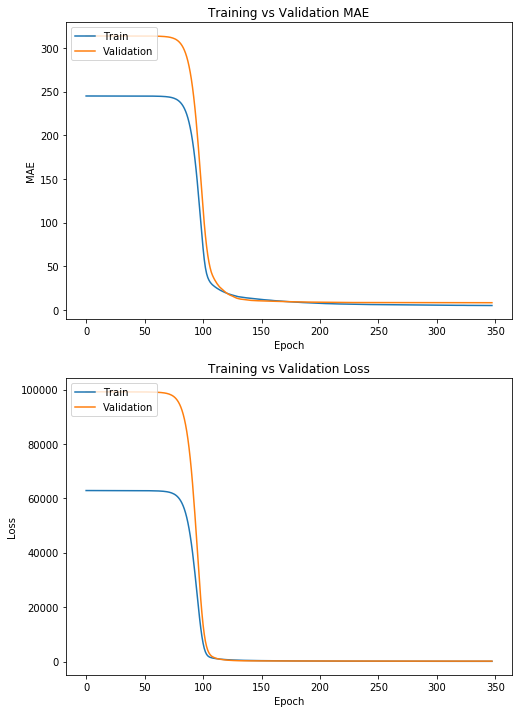

In [19]:
plot_hist(history.history, xsize=8, ysize=12)

In [20]:
preds = model.predict(test_set)


In [21]:
len(preds)

100

In [22]:
preds

array([[315.51724],
       [310.71765],
       [317.1397 ],
       [322.2642 ],
       [318.2141 ],
       [317.2385 ],
       [301.8388 ],
       [301.37473],
       [302.9041 ],
       [306.0166 ],
       [302.152  ],
       [292.20242],
       [295.08337],
       [298.89563],
       [345.37354],
       [350.60803],
       [346.72357],
       [365.9347 ],
       [370.26205],
       [360.63474],
       [355.0511 ],
       [357.92953],
       [352.8086 ],
       [340.3836 ],
       [337.55374],
       [322.09995],
       [304.33972],
       [319.65448],
       [319.9378 ],
       [320.6393 ],
       [320.39972],
       [319.8156 ],
       [314.9178 ],
       [307.20596],
       [301.10318],
       [301.4557 ],
       [292.54694],
       [282.7526 ],
       [284.61923],
       [264.93835],
       [279.99362],
       [278.4137 ],
       [285.95624],
       [289.8663 ],
       [292.2841 ],
       [293.93005],
       [294.5133 ],
       [291.35413],
       [300.31363],
       [297.86682],


In [23]:
test_y

matrix([[310.1 ],
        [322.69],
        [323.85],
        [320.23],
        [313.58],
        [303.2 ],
        [297.43],
        [308.74],
        [306.65],
        [297.18],
        [290.17],
        [298.14],
        [300.84],
        [349.54],
        [348.17],
        [341.99],
        [379.57],
        [370.34],
        [352.45],
        [355.49],
        [356.41],
        [347.64],
        [338.69],
        [335.45],
        [305.5 ],
        [308.44],
        [321.9 ],
        [321.64],
        [320.1 ],
        [322.82],
        [319.27],
        [311.86],
        [305.01],
        [303.15],
        [301.66],
        [288.95],
        [280.74],
        [280.95],
        [263.24],
        [285.5 ],
        [279.44],
        [290.54],
        [289.46],
        [295.2 ],
        [294.84],
        [284.96],
        [299.02],
        [298.33],
        [299.1 ],
        [299.68],
        [300.99],
        [309.58],
        [307.52],
        [264.77],
        [310.7 ],
        [3

In [24]:
tsla.data['date'].values
print(tsla.data['open'].values)

[148.48 147.58 152.24 ... 341.83 360.   356.05]


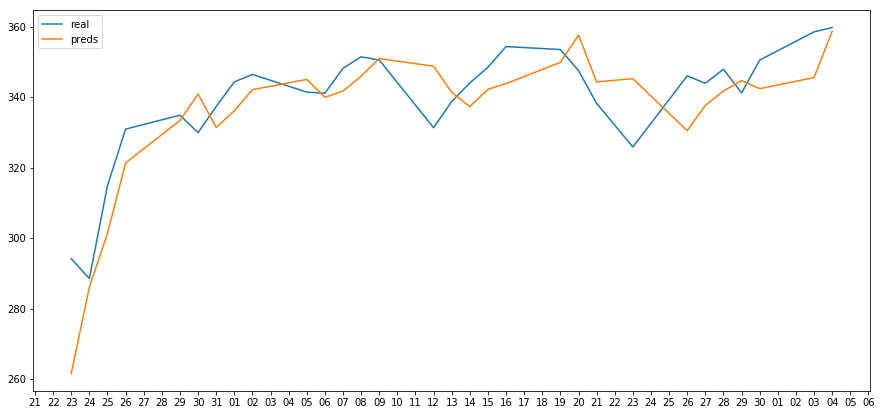

In [27]:
fig, ax = plt.subplots(figsize=(15,7))
num = 30
ax.plot(tsla.data['date'].values[ len(tsla.data)-num:len(tsla.data)], test_y[testNum-num:testNum])
ax.plot(tsla.data['date'].values[ len(tsla.data)-num:len(tsla.data)], preds[testNum-num:testNum])
#ax.plot(tsla.data['date'].values[ len(tsla.data)-num:len(tsla.data)], tsla.data['close'].values[len(tsla.data)-1-num:len(tsla.data)-1])
ax.legend(['real', 'preds','open'], loc='upper left')
ax.xaxis.set_major_locator(mdates.DayLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d'))

In [26]:
print(len(preds))
print(len(test_y))

100
100
